In [12]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as iio
import cv2

import tensorflow as tf
import tensorflow.keras as keras
import keras.models as models
import keras.layers as layers
from keras.applications.efficientnet import EfficientNetB0

from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
# set constants
TRAINING_IMAGES_DIR = 'data/images/TRAIN' # directory/path to training images
TEST_IMAGES_DIR = 'data/images/TEST' # directory/path to test images
TRAINING_LABELS_PATH = 'data/labels.csv' # path to training labels csv

# image size (required by EfficientNet)
IMAGE_HEIGHT = 224 # pixels
IMAGE_WIDTH = 224 # pixels

# dictionaries mapping each label to an integer representation (or vice versa)
REP_TO_LABELS = {0: 'EOSINOPHIL', 1: 'LYMPHOCYTE', 2: 'MONOCYTE', 3: 'NEUTROPHIL'}
LABELS_TO_REP = {'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}

In [3]:
def load_images(dir):
    """
    Loads the images at the directory path dir into an ndarray, then returns it
    with a corresponding list of training labels (from the directory name) and
    the names of the image files.

    Parameters
    ----------
    dir: path to image directory
    
    Returns
    -------
    images: ndarray of size (num images, 240, 320, 3)
    images_names: list of len (num images)
    labels: list of len (num images)
    """
    # create empty lists to store image data
    images_list = [] # ndarrays for the training images
    images_names = [] # the filename of the image
    labels = [] # the true label for the image

    # loop through directory:
    for dirpath, dirnames, filenames in os.walk(dir):
        for file in filenames:
            # append resized image
            images_list.append(cv2.resize(src=iio.imread(uri = os.path.join(dirpath, file)),
                                          dsize=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                          interpolation=cv2.INTER_AREA))
            images_names.append(file)
            # assign the image a rep based on the directory it lies in
            labels.append(LABELS_TO_REP[Path(dirpath).stem])

    # stack all images into one array and normalize values to [0,1]
    images = np.stack(images_list, axis=0)/255

    return images, images_names, labels

In [4]:
def batch_resize(images, new_shape):
    """
    Resizes all images into desired shape (by batch).

    Parameters
    ----------
    images: 4D ndarray of images of shape (number images, height, width, channels)
    new_shape: tuple of (new_height, new_width)
    
    Returns
    -------
    out_images: 4D ndarray of images of shape (number images, new_height, new_width, channels)
    """

    num_images, old_height, old_width, channels = images.shape
    
    out_images_list = [] # empty array to store each batch

    for i in range(0, num_images):
        resized_image = cv2.resize(src=images[i, :, :, :].copy(), dsize=new_shape, interpolation=cv2.INTER_AREA)
        
        out_images_list.append(resized_image)

    out_images = np.stack(out_images_list, axis=0)
    return out_images

In [5]:
# load training images and labels
train_images, train_images_names, train_labels = load_images(TRAINING_IMAGES_DIR)

In [15]:
train_labels = np.array(train_labels)

In [16]:
# split validation data (evenly split between classes)
sss = StratifiedShuffleSplit(n_splits = 1, test_size=0.2)
for train_index, val_index in sss.split(train_images, train_labels):
    X_train, X_val = train_images[train_index], train_images[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]

In [6]:
# load test images and labels
# test_images, test_images_names, test_labels = load_images(TEST_IMAGES_DIR)

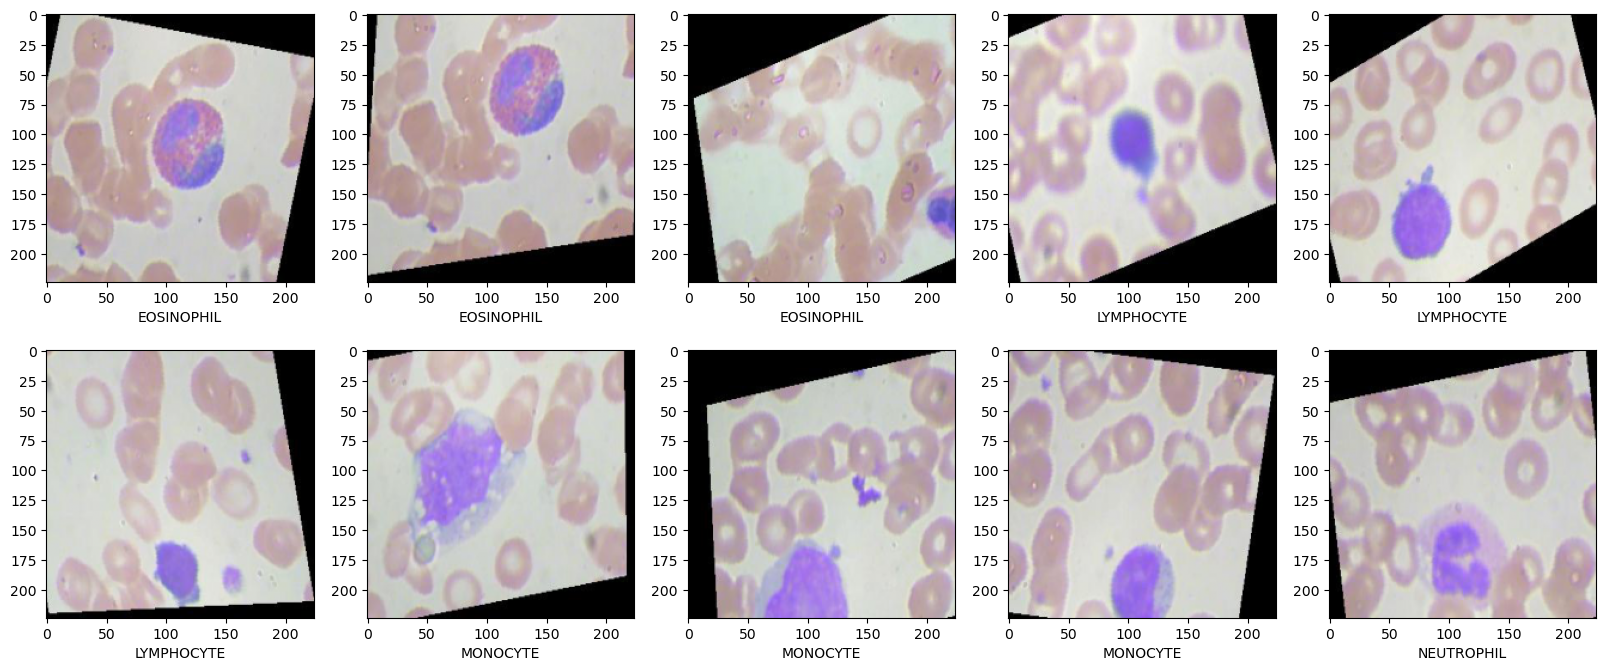

In [7]:
# display 10 cell images
fig, axs = plt.subplots(2, 5, figsize=(20,8))
count = 0
for i in range(2):
    for j in range(5):
        axs[i,j].imshow(train_images[850*count,:,:,:].reshape([IMAGE_HEIGHT,IMAGE_WIDTH,3]))
        # axs[i,j].axis("off")
        axs[i,j].set_xlabel(REP_TO_LABELS[train_labels[850*count]])
        count+=1
plt.show()

<BarContainer object of 4 artists>

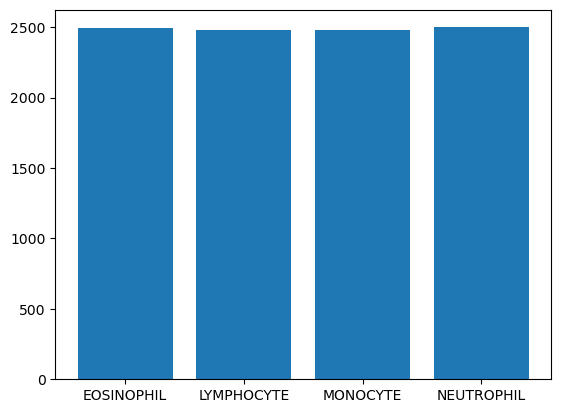

In [8]:
# histogram of labels
labels = pd.Series(train_labels)
plt.bar(REP_TO_LABELS.values(), height=labels.groupby(labels).size())

In [9]:
# load EfficientNet 
enet = EfficientNetB0(include_top=False, input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3))
enet.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0

In [17]:
# freeze efficientnet layers
for layer in enet.layers:
    layer.trainable = False

# add final prediction layers
model_enet_tl = models.Sequential([enet, 
                                   layers.GlobalAveragePooling2D(),
                                   layers.BatchNormalization(),
                                   layers.Dropout(0.2),
                                   layers.Dense(4)])

model_enet_tl.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 4,059,815
Trainable params: 7,684
Non-tr

In [11]:
# stop early if loss stops improving
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# compile model
model_enet_tl.compile(optimizer='adam',
                      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

# train prediction layers
history_enet_tl = model_enet_tl.fit(tf.constant(X_train, dtype=tf.float64),
                                    tf.constant(y_train, dtype=tf.int8),
                                    epochs=20,
                                    batch_size=10,
                                    validation_data=(X_val, y_val),
                                    callbacks=[early_stop])

Epoch 1/20
797/797 [==============================] - 187s 223ms/step - loss: 1.3072 - accuracy: 0.3085 - val_loss: 2.9176 - val_accuracy: 0.0000e+00
Epoch 2/20
185/797 [=====>........................] - ETA: 1:45 - loss: 1.2948 - accuracy: 0.3054

KeyboardInterrupt: 

In [ ]:
# fine tuning:

# unfreeze top twenty layers except batchnormalization
for layer in model_enet_tl.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

# recompile model
model_enet_tl.compile(optimizer=keras.optimizers.Adam(1e-5),
                      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy']

# train
history_enet_tuned = model_enet_tl.fit(X_val,
                                       y_val,
                                       epochs=4,
                                       validation_data=(X_val, y_val))

In [ ]:
# save weights
model_enet_t1.save_weights("bloodcell-efficientnetb0_weights.h5")